### Plot main results:  
    - heatmap of information as function of model parameters (horiz/ama weight vs center/surround weight)  
    - where ganglion cells map onto this heatmap
    - cumulative information of full model, horizontal, amacrine only models, ganglion cell, ideal filter, center vs frequency
    - total information vs SNR

In [66]:
import numpy as np
import collections
from functools import partial

from surround.image_processing import *
from surround.data_handling import *
from aesthetics.plotting import *
from surround.modeling import difference_of_gaussians

from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

### Receptive fields of ganglion, bipolar, amacrine, and horizontal cells

In [5]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

Verify that spacings for all cells is the same

In [12]:
spacings = []
for c in cells.keys():
    print(c)
    for space, rf in cells[c]:
        spacings.append(space)
samplerates = [float('%0.6f' %np.mean(np.diff(s))) for s in spacings]
print(np.unique(samplerates))

horizontal
amacrine
bipolar
ganglion
[ 0.444444  0.546835]


There are 2 different types of spacing. Let's take the average.

In [24]:
average_spacing = np.mean(np.stack([s for s in spacings if len(s)==80]), axis=0)
average_spacing -= np.min(abs(average_spacing)) # sample the peak at 0
average_spacing.shape

(80,)

In [26]:
np.mean(np.diff(average_spacing))

0.54683544303797449

Interpolate all of the receptive fields to be at the same spacing

In [30]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for space, rf in cells[c]:
        this_cell_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(average_spacing))

Plot them as a sanity check

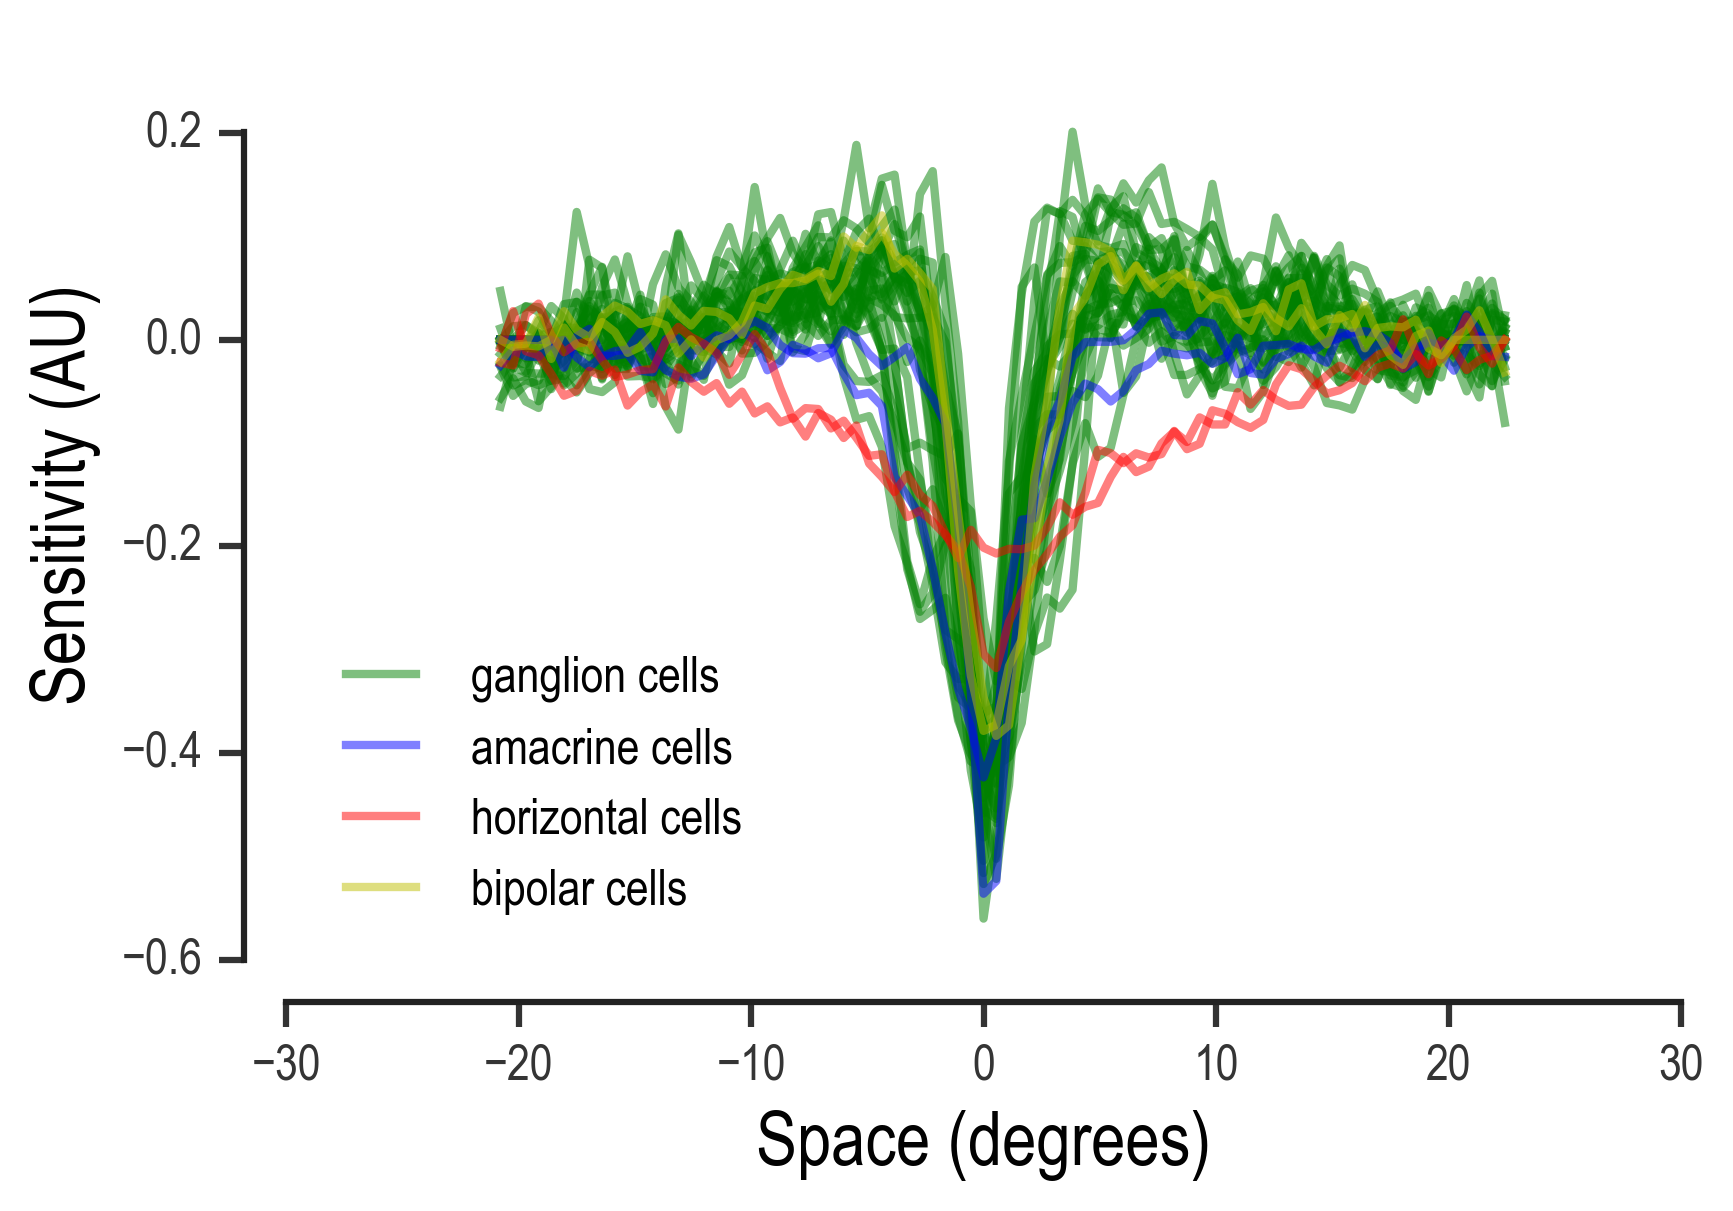

In [41]:
colorscheme = 'gbry'
for idc, c in enumerate(receptive_fields.keys()):
    this_color = colorscheme[idc]
    for idrf, rf in enumerate(receptive_fields[c]):
        if idrf == 0:
            plt.plot(average_spacing, rf, color=this_color, linewidth=2, alpha=0.5, label='%s cells' %c)
        else:
            plt.plot(average_spacing, rf, color=this_color, linewidth=2, alpha=0.5)

plt.ylabel('Sensitivity (AU)', fontsize=18)
plt.xlabel('Space (degrees)', fontsize=18)
plt.legend(frameon=False, loc='lower left', fontsize=12)
adjust_spines(plt.gca())

### Projective fields of amacrine and horizontal cells

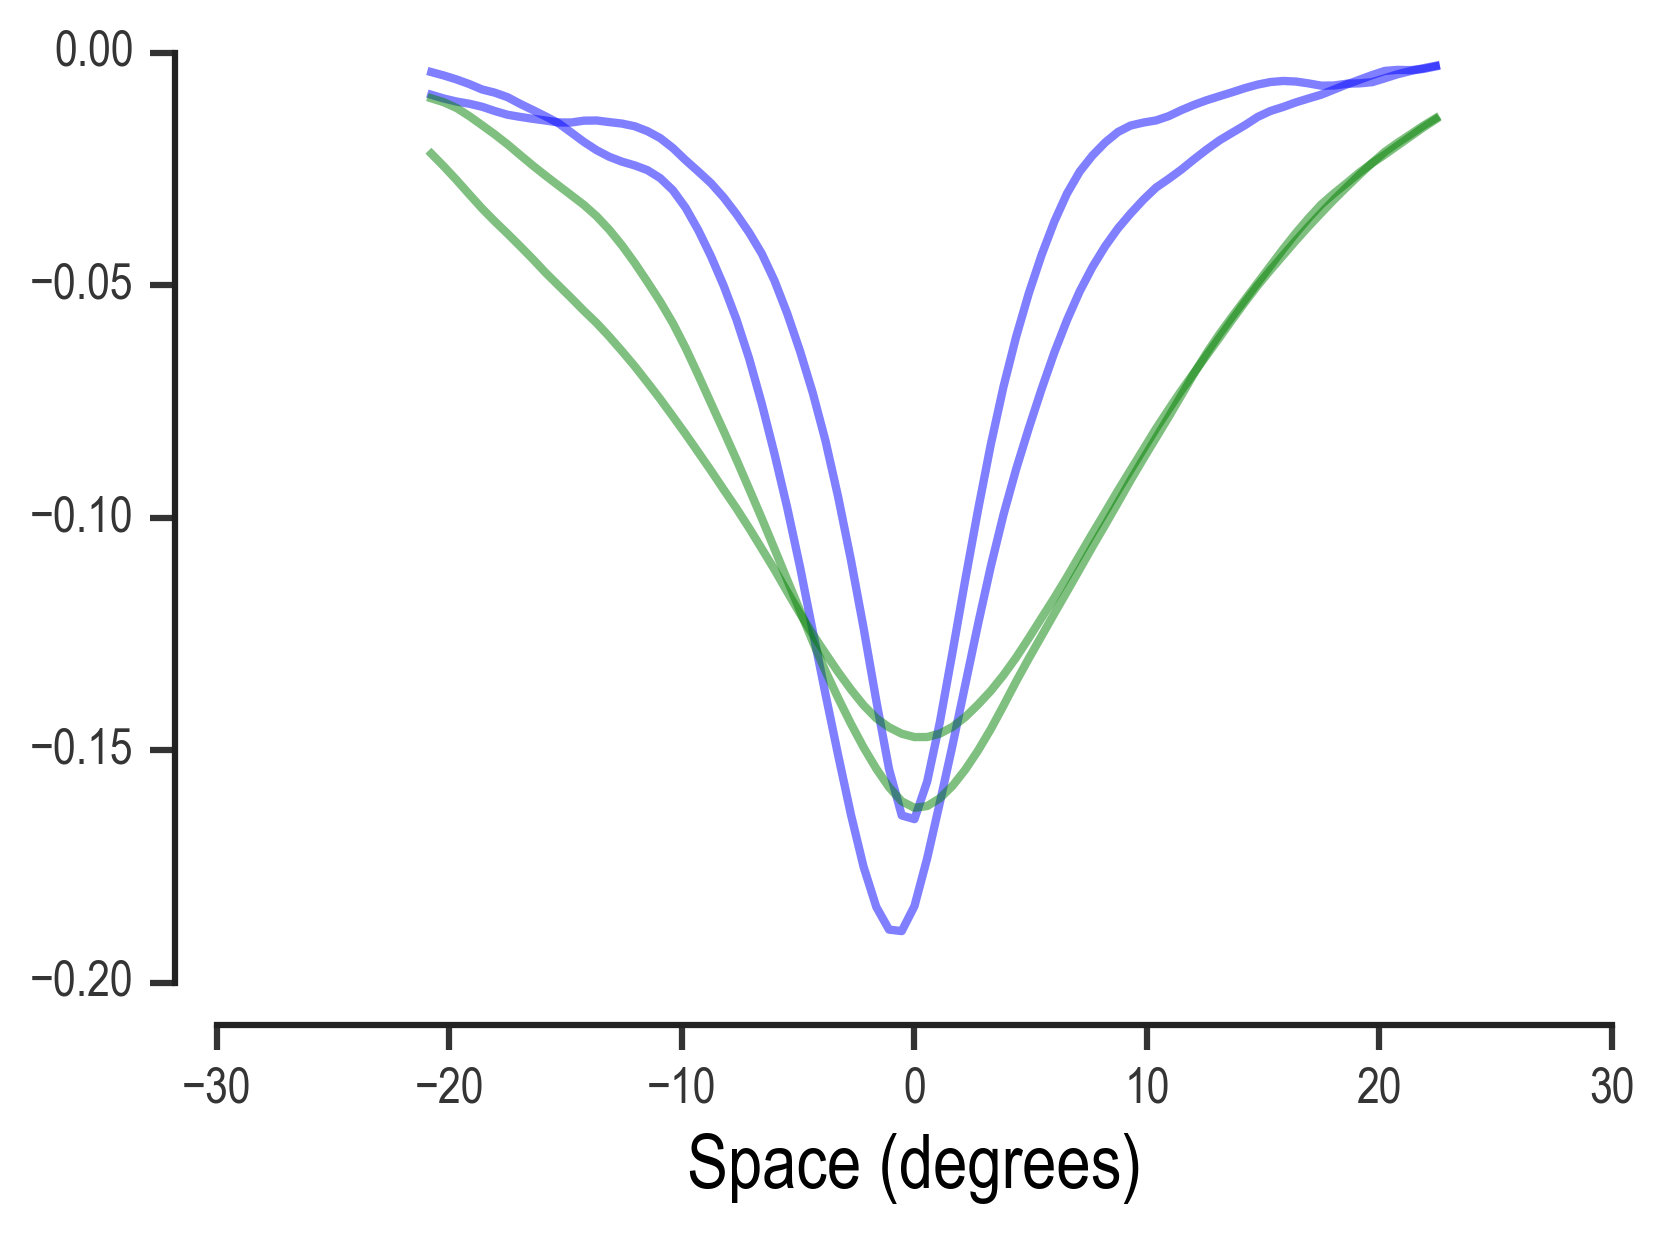

In [119]:
space_constants = {'horizontal': 118./22., 'amacrine': 78./22.}

projective_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['horizontal', 'amacrine']:
        for rf in receptive_fields[celltype]:
            spatial_smoothing = [np.exp(-abs(t)/space_constants[celltype]) for t in np.linspace(np.min(average_spacing),
                                                                                                np.max(average_spacing),
                                                                                                len(average_spacing))]
            proj_field = np.convolve(spatial_smoothing, rf, mode='same')
            proj_field *= np.mean(rf) / np.mean(proj_field)
            projective_fields[celltype].append(proj_field)

colorscheme = 'bg'
for i,celltype in enumerate(sorted(projective_fields.keys())):
    this_color = colorscheme[i]
    for pf in projective_fields[celltype]:
        plt.plot(average_spacing, pf, color=this_color, alpha=0.5, linewidth=2)
plt.xlabel('Space (degrees)', fontsize=18)
adjust_spines(plt.gca())

### Signal

Get the frequency range for average_spacing

In [51]:
freqs = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), len(np.fft.rfft(average_spacing)))

In [42]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [46]:
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches01A, spacing=spacing)

Interpolate signal at same resolution and scale as cell measurements

In [52]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt)
signal = func(freqs, *popt)

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


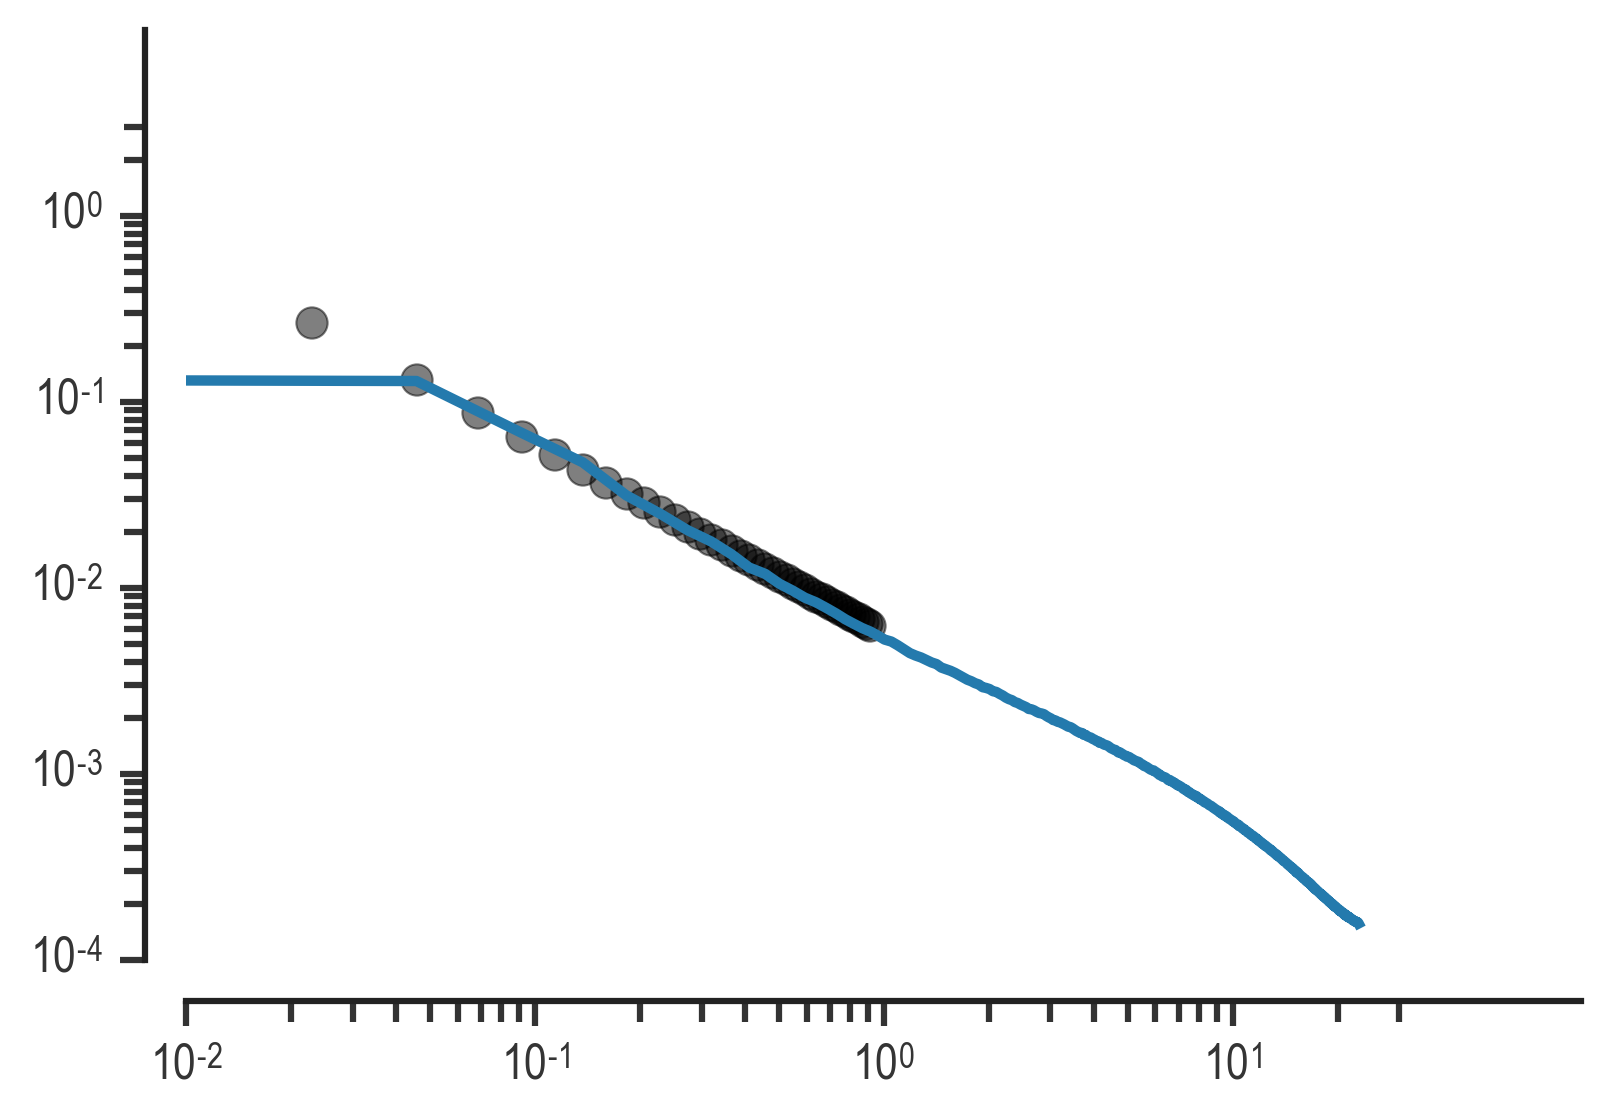

In [54]:
plt.plot(freqs, signal, 'k.', alpha=0.5)
plt.plot(signal_freqs, signal_amps)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())

In [55]:
spacing

0.021739130434782608

In [56]:
np.mean(np.diff(average_spacing))

0.54683544303797449

In [86]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0.)

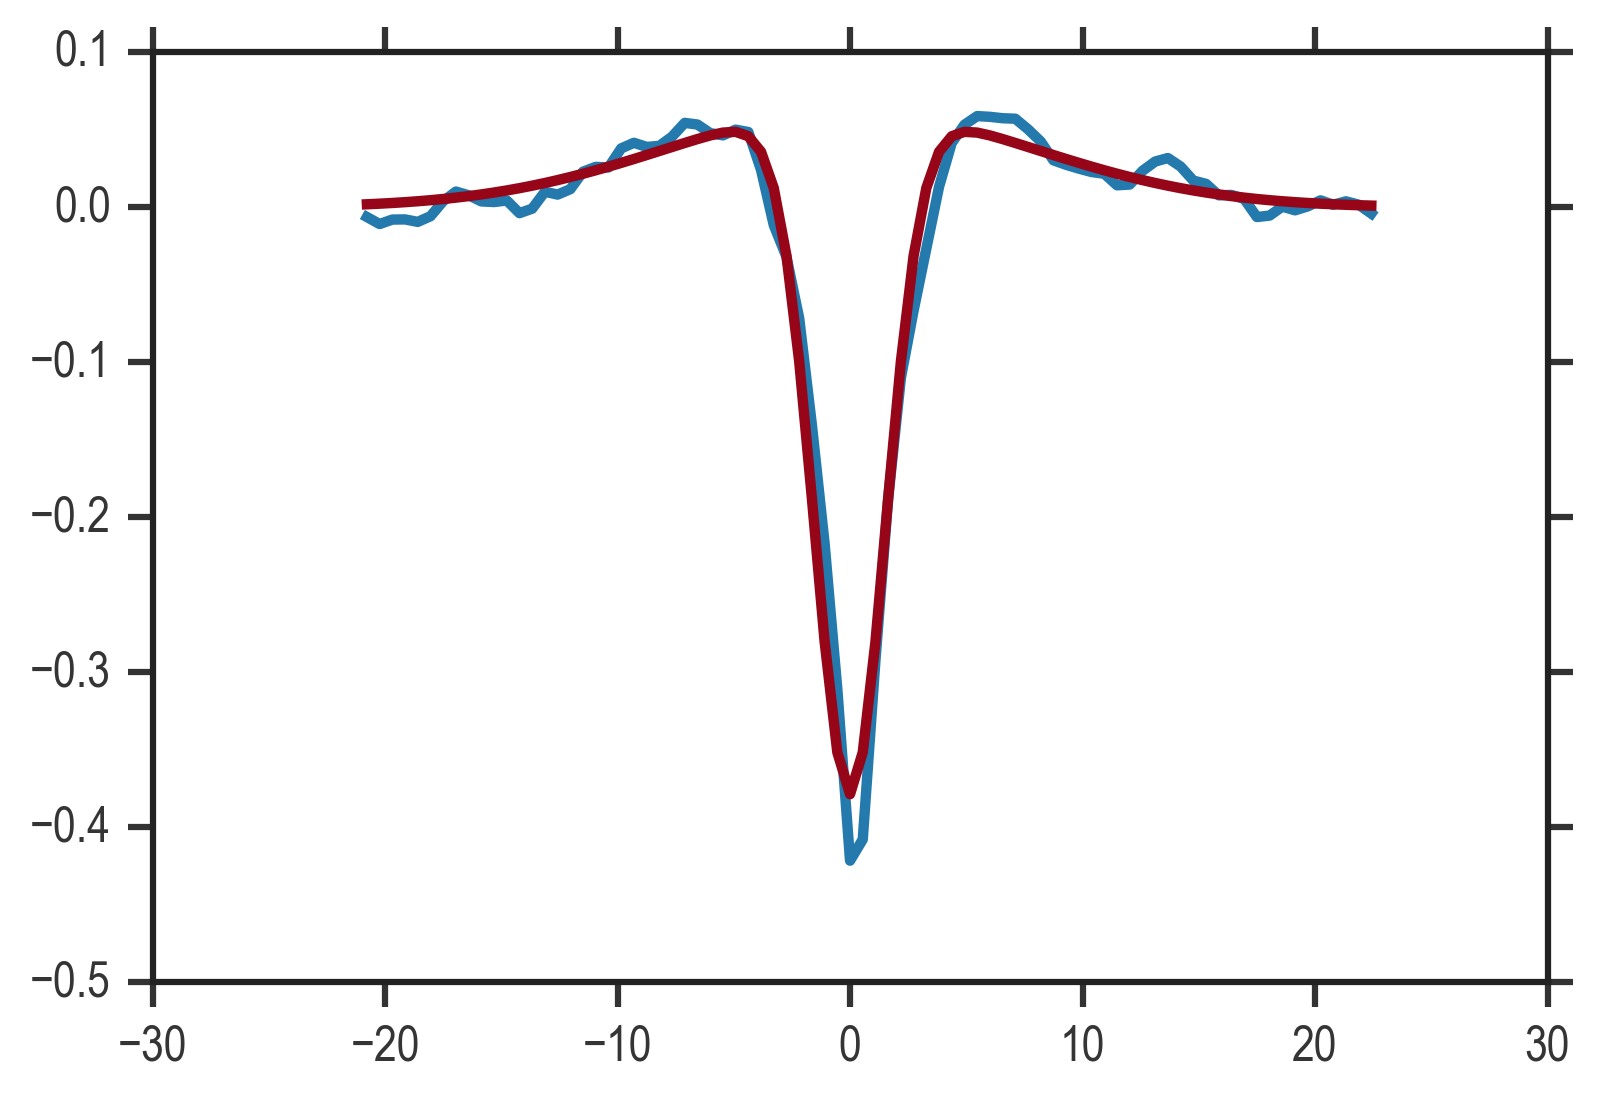

In [87]:
average_ganglion = np.mean(np.stack(receptive_fields['ganglion']), axis=0)
popt, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, average_ganglion)
plt.plot(average_spacing, average_ganglion)
plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt))

Couldn't fit cell 15
Couldn't fit cell 21
Couldn't fit cell 27


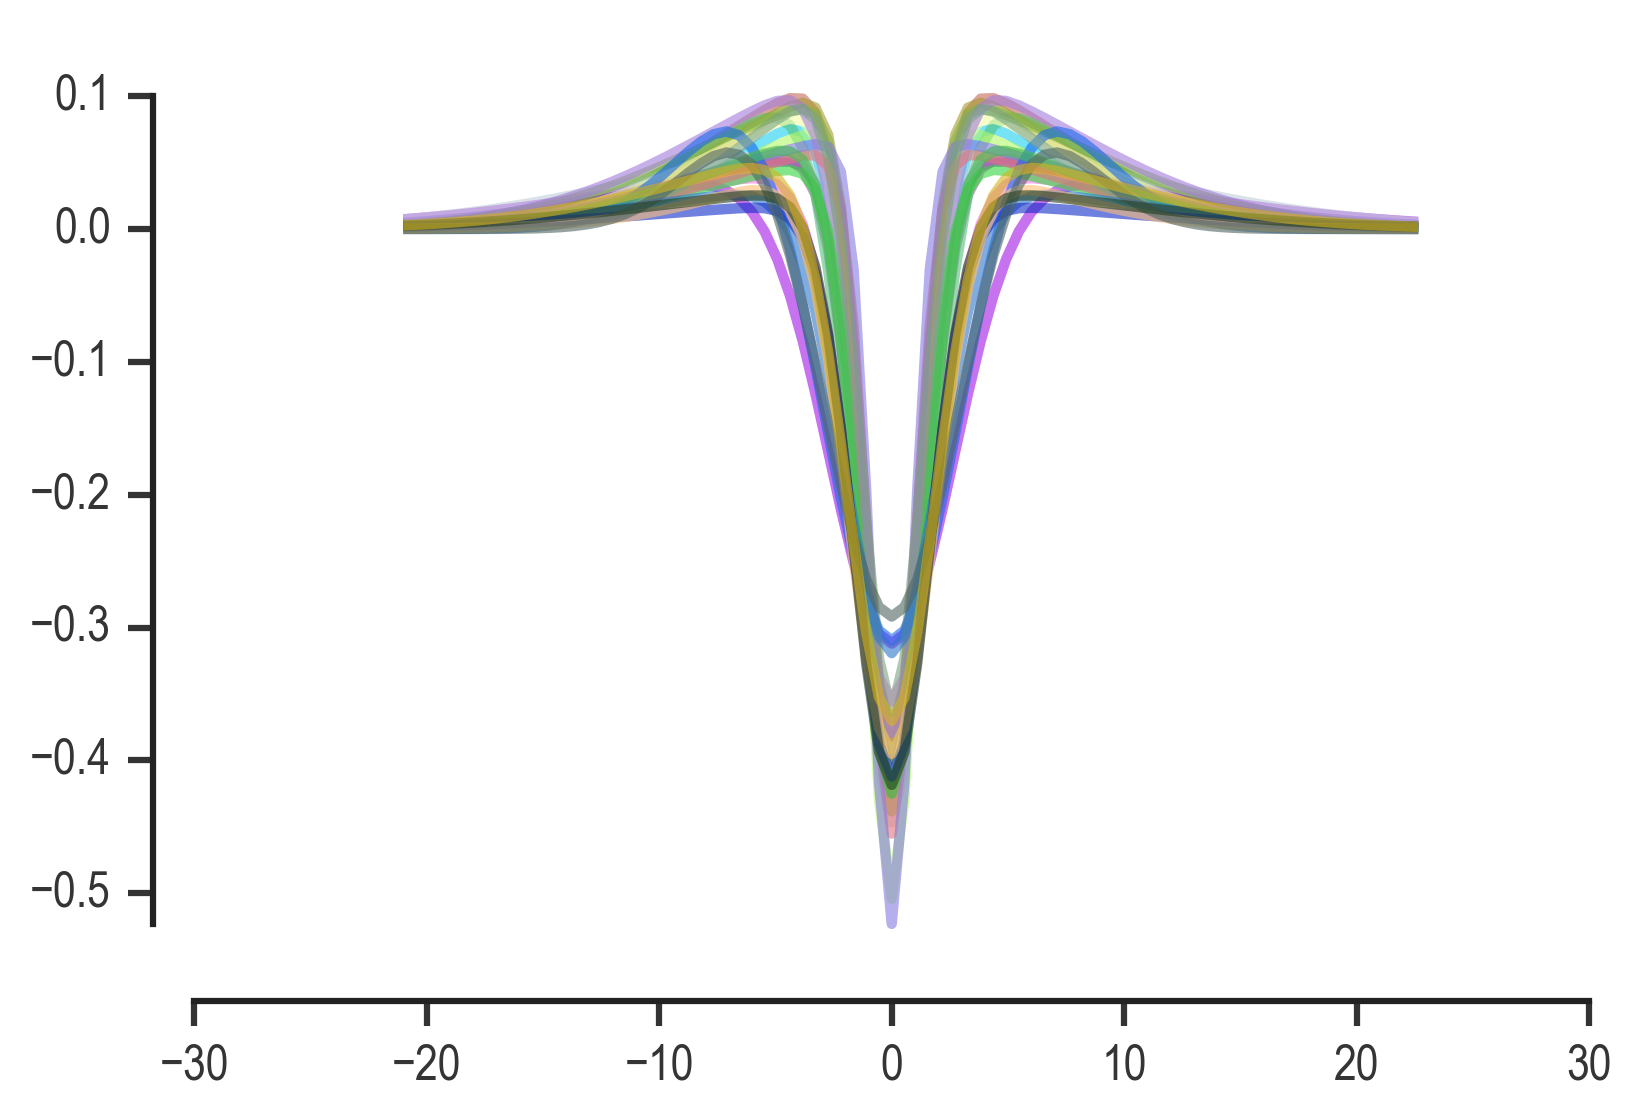

In [93]:
center_widths = []
surround_widths = []
for idg, g in enumerate(receptive_fields['ganglion']):
    try:
        popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g, p0=popt)
        center_widths.append(np.min(abs(popt_this[:2])))
        surround_widths.append(np.max(abs(popt_this[:2])))
        plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), color=np.random.rand(3), alpha=0.6)
    except:
        print("Couldn't fit cell %d" %idg)
        
plt.ylim(-.55, .15)
adjust_spines(plt.gca())

In [95]:
np.mean(surround_widths)

7.4899876868915491

In [96]:
np.mean(center_widths)

1.6329005789098545

In [101]:
tuple(np.random.choice(average_spacing, 2))

(1.6405063291139228, 19.139240506329109)

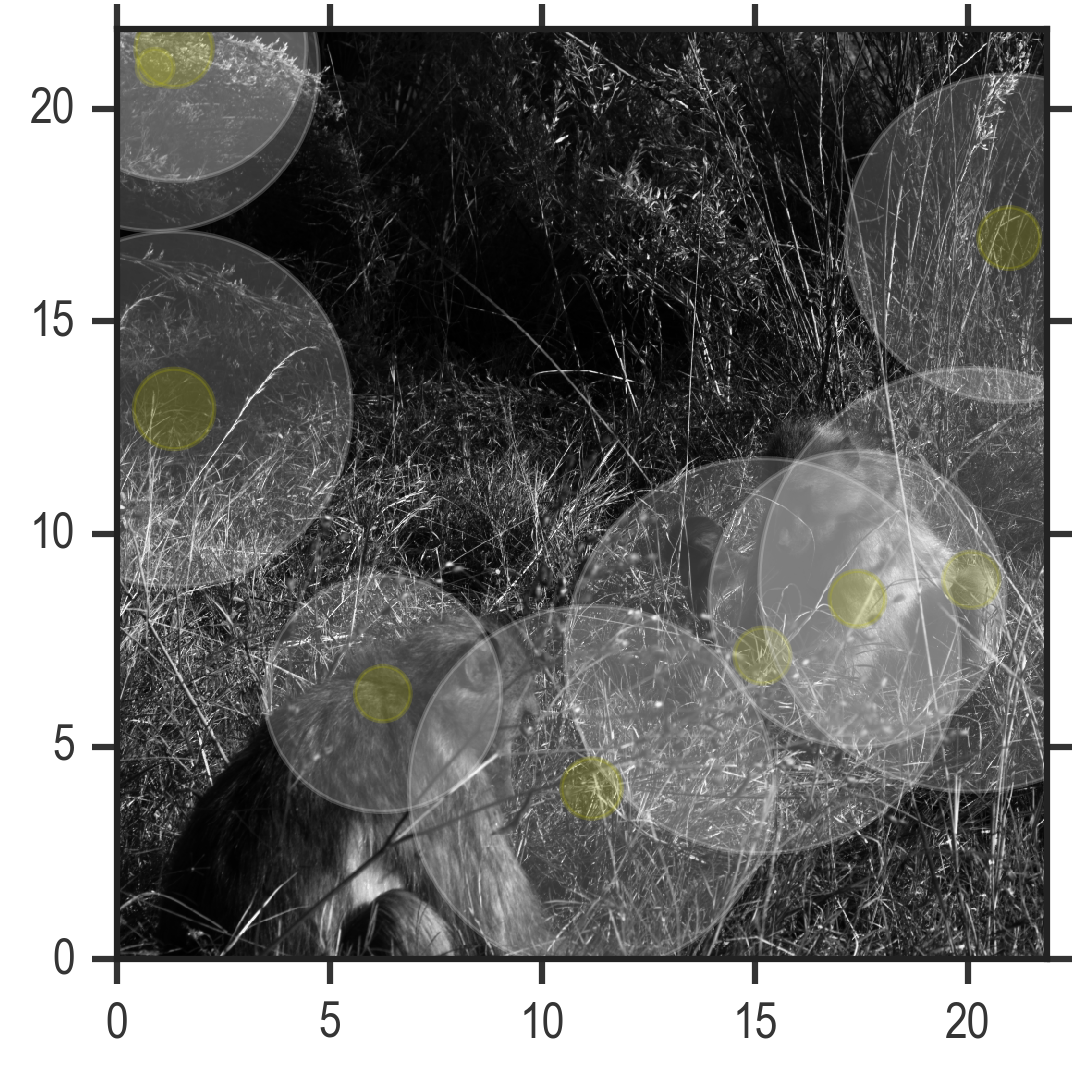

In [112]:
image_id = 15
plt.imshow(patches01A[image_id], extent=[0, spacing*patches01A[image_id].shape[0],
                                         0, spacing*patches01A[image_id].shape[0]])
ax = plt.gca()

center_choices = np.linspace(0, spacing*patches01A[1].shape[0])
for idc, center_diameter in enumerate(center_widths):
    # select a subset
    if idc % 3 == 0:
        center = tuple(np.random.choice(center_choices, 2))
        circle_surround = plt.Circle(center, surround_widths[idc]/2, color='w', alpha=0.2)
        circle_center = plt.Circle(center, center_diameter/2, color='y', alpha=0.2)

        ax.add_artist(circle_surround)
        ax.add_artist(circle_center)

Salamanders have very low resolution eyes!

### Noise

In [ ]:
input_noise = np.array([0.12]*len(freqs))
output_noise = np.array([0.35]*len(freqs))

# David's ganglion cells on heatmap

In [157]:
from os.path import expanduser
import pyret.filtertools as ft
from sklearn.decomposition import PCA
from surround.modeling import gaussian

In [ ]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [149]:
fast_on_rfs = []
for c in fast_on:
    # since receptive fields are noisy, use PCA
    pca = PCA(n_components=2)
    pca.fit(c)
    g_pca = pca.components_[0]

    sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
    space      = get_space(g_pca, spatialDelta, micronsPerDeg)

    fast_on_rfs.append((space, sign_of_pc * g_pca))

In [151]:
aligned_fast_on = []
for space, rf in fast_on_rfs:
    rf_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
    aligned_fast_on.append(rf_interp(average_spacing))

In [158]:
def rf_express(horz_weight, center_weight, center_width=np.mean(center_widths), return_space=False):
    horz_weight = np.min([1.0, abs(horz_weight)])
    ama_weight = 1.0 - horz_weight
    center_weight = np.min([1.0, abs(center_weight)])
    surround_weight = 1.0 - center_weight
    
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround
    
    if return_space:
        return space, rf
    else:
        return rf

In [172]:
fits = []
errors = []
for i,rf in enumerate(aligned_fast_on):
    def model_error_to_ganglion_cells(weights, valid_space=average_spacing, mean_ganglion=rf):
        horz_weight, center_weight = weights
        space, rf = rf_express(horz_weight, center_weight, return_space=True)
        model_rf = interp1d(space, -rf, kind='slinear', bounds_error=False, fill_value=[0]) # negative since we have OFF cells
        normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
        return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))
    
    popt = minimize(model_error_to_ganglion_cells, np.array([0.8,0.9]))
    
    # truncate params between 0 and 1
    x = np.where(popt.x < 0, 0, popt.x)
    x = np.where(x > 1, 1, x)
    
    fits.append(x)
    errors.append(popt.fun)
    print('Fit ganglion cell %d/%d.' %(i,len(aligned_fast_on)))

Fit ganglion cell 0/126.
Fit ganglion cell 1/126.
Fit ganglion cell 2/126.
Fit ganglion cell 3/126.
Fit ganglion cell 4/126.
Fit ganglion cell 5/126.
Fit ganglion cell 6/126.
Fit ganglion cell 7/126.
Fit ganglion cell 8/126.
Fit ganglion cell 9/126.
Fit ganglion cell 10/126.
Fit ganglion cell 11/126.
Fit ganglion cell 12/126.
Fit ganglion cell 13/126.
Fit ganglion cell 14/126.
Fit ganglion cell 15/126.
Fit ganglion cell 16/126.
Fit ganglion cell 17/126.
Fit ganglion cell 18/126.
Fit ganglion cell 19/126.
Fit ganglion cell 20/126.
Fit ganglion cell 21/126.
Fit ganglion cell 22/126.
Fit ganglion cell 23/126.
Fit ganglion cell 24/126.
Fit ganglion cell 25/126.
Fit ganglion cell 26/126.
Fit ganglion cell 27/126.
Fit ganglion cell 28/126.
Fit ganglion cell 29/126.
Fit ganglion cell 30/126.
Fit ganglion cell 31/126.
Fit ganglion cell 32/126.
Fit ganglion cell 33/126.
Fit ganglion cell 34/126.
Fit ganglion cell 35/126.
Fit ganglion cell 36/126.
Fit ganglion cell 37/126.
Fit ganglion cell 38/1

In [173]:
fits_array = np.stack(fits)
fits_array.shape

(126, 2)

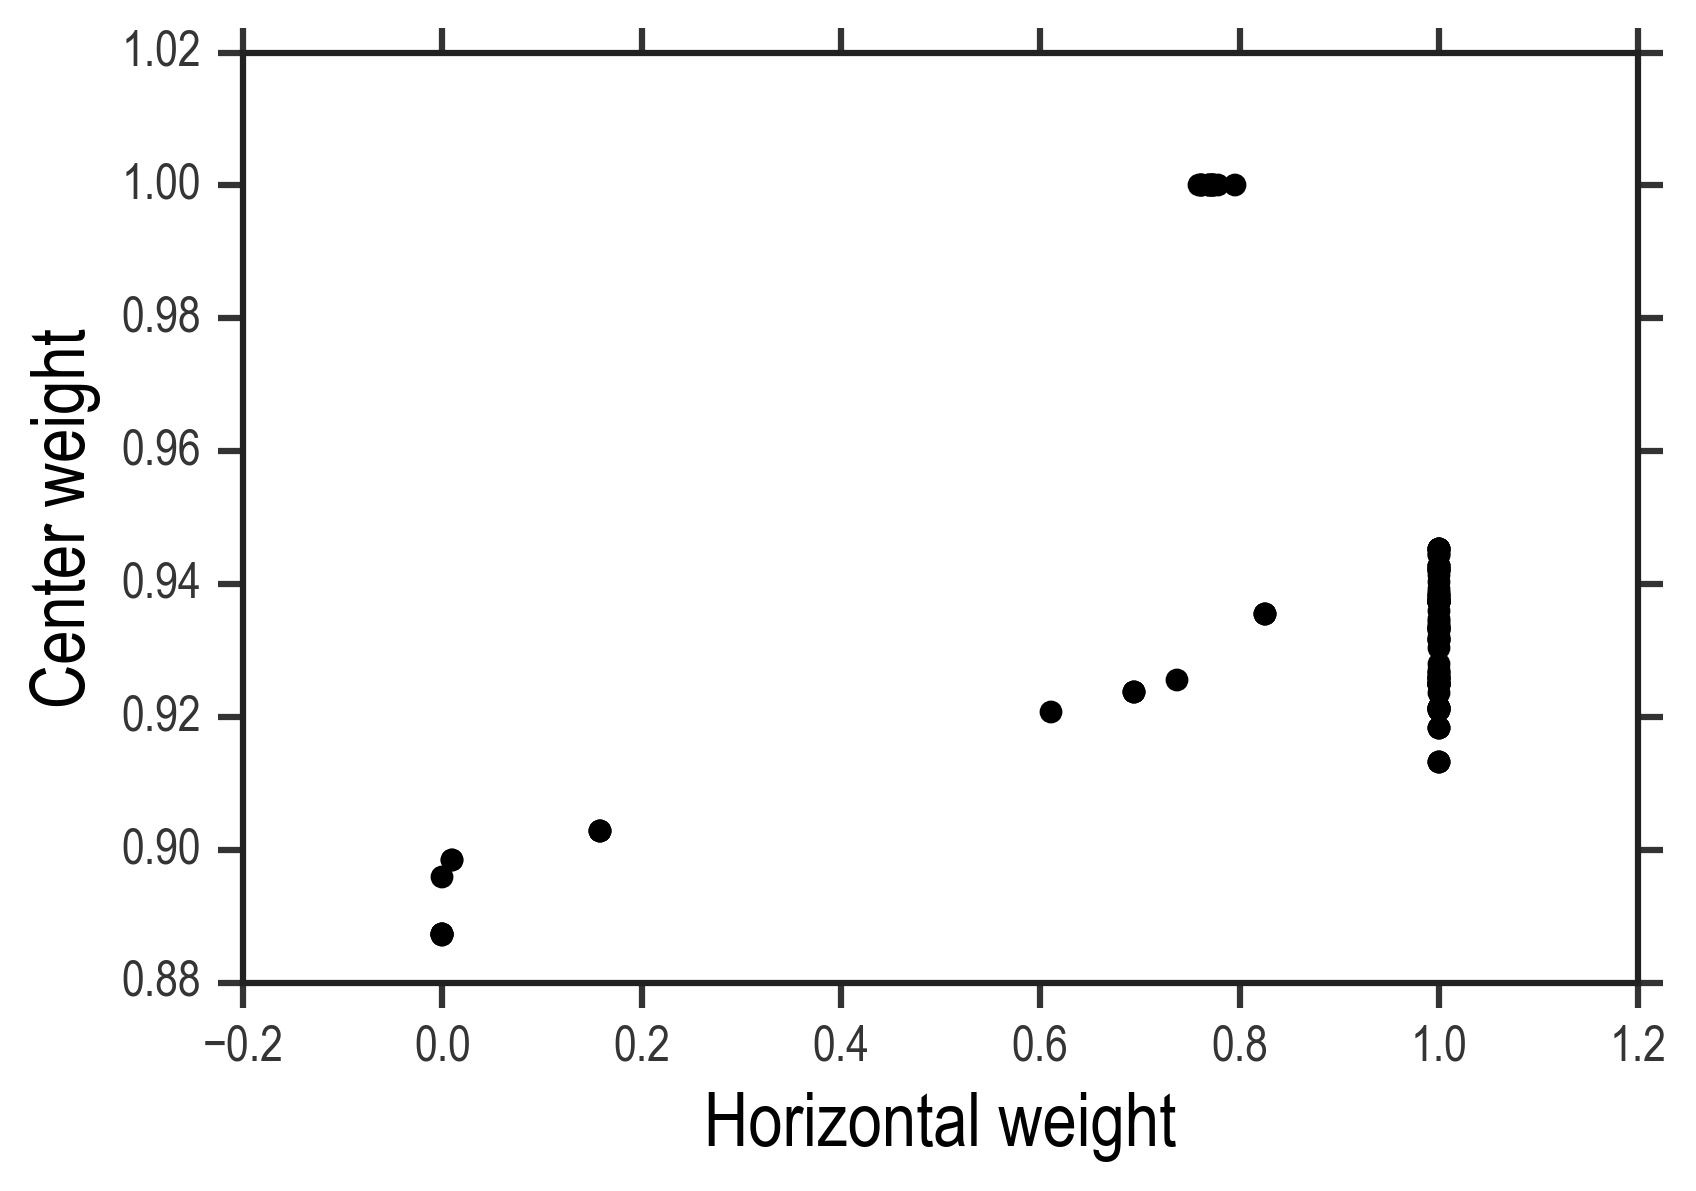

In [174]:
plt.scatter(fits_array[:,0], fits_array[:,1], c='k')
plt.xlabel('Horizontal weight', fontsize=18)
plt.ylabel('Center weight', fontsize=18)

### Load heatmap

In [175]:
import h5py

In [176]:
with h5py.File('info_grid_search.h5', 'r') as f:
    info_color_map = np.array(f['info_colormap'])
    center_weights = np.array(f['center_weight_xaxis'])
    horz_weights = np.array(f['horz_weight_yaxis'])

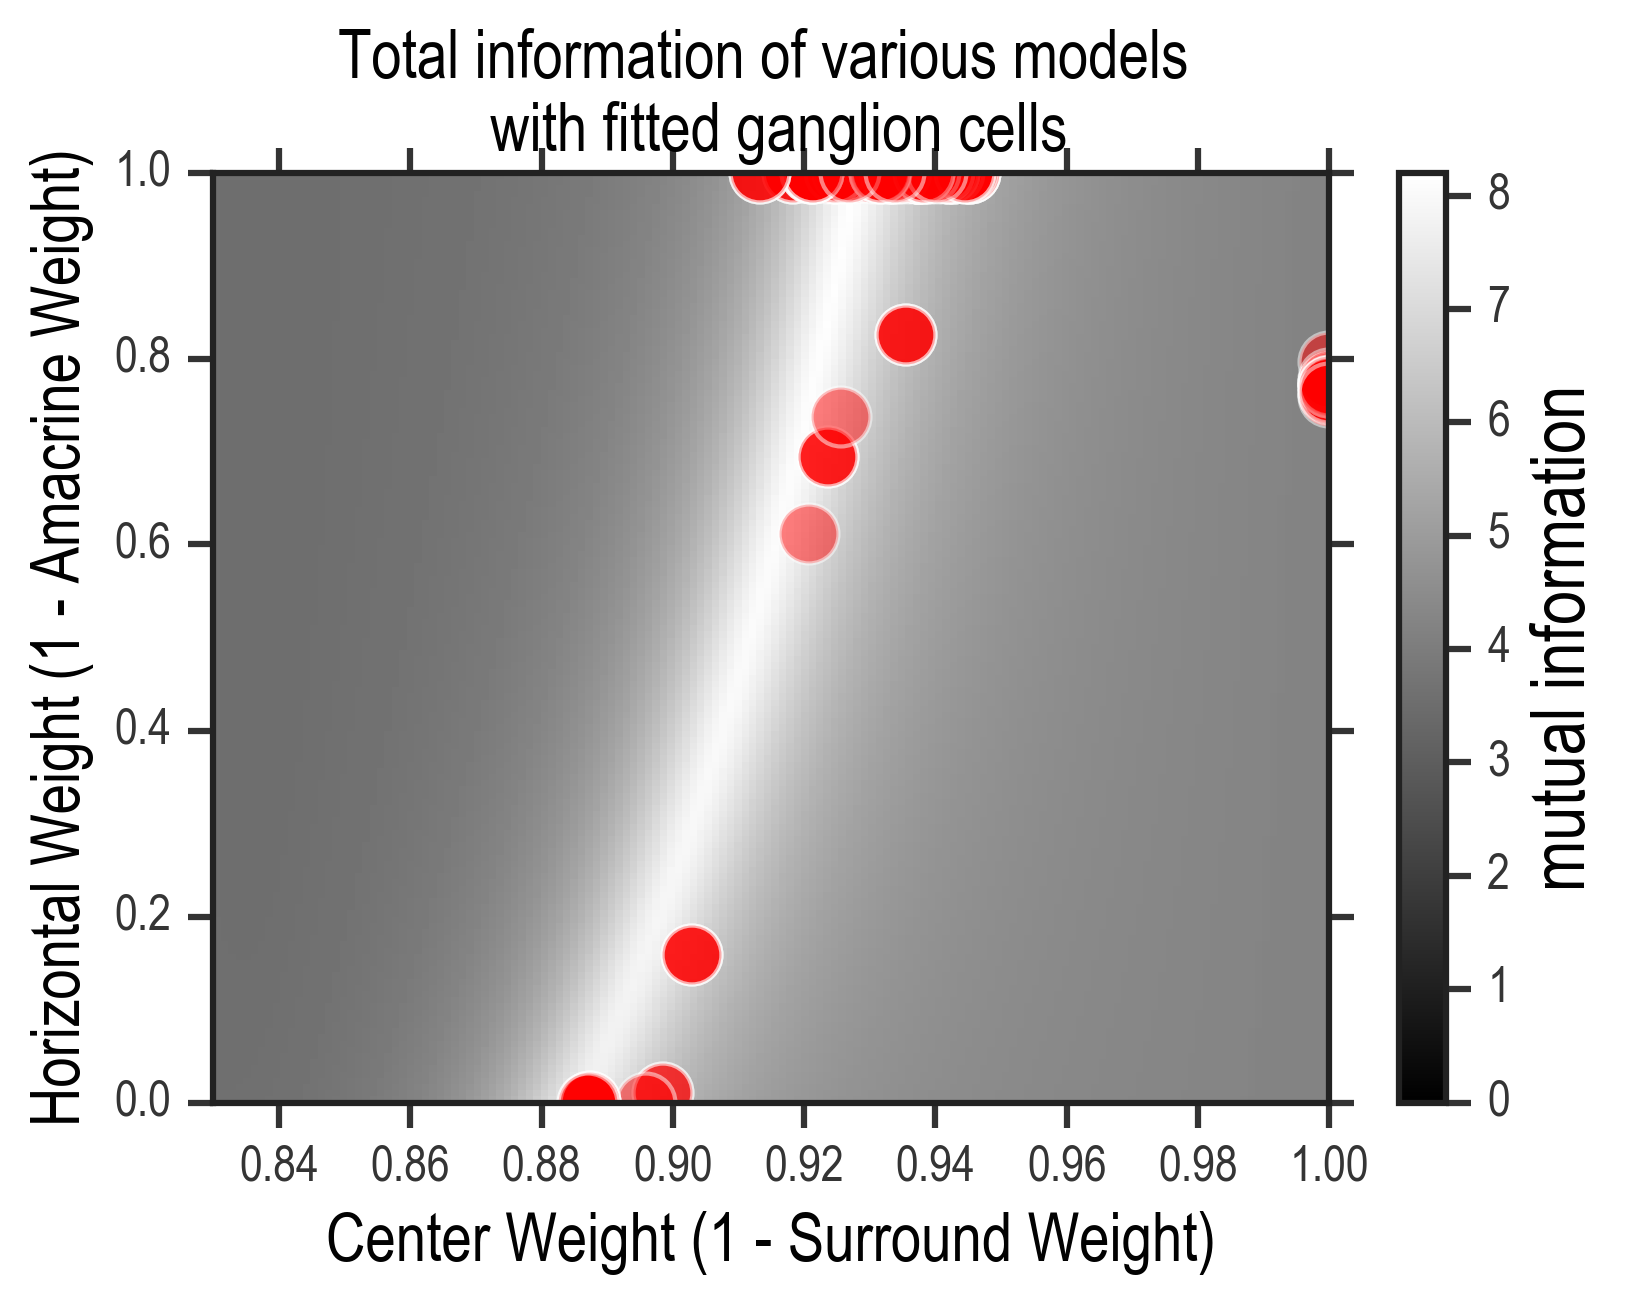

In [192]:
plt.imshow(info_color_map, extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
cbar = plt.colorbar()
plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('mutual information', fontsize=18)
plt.scatter(fits_array[:,1], np.where(fits_array[:,0] > 1, 1, fits_array[:,0]), c='r', edgecolor='w', s=200, 
            alpha=0.5, label='fast on')
# plt.xlim([0,1])
# plt.legend(loc='upper left', frameon=False)
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])
plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)